In [4]:
using Plots
using DataFrames
using CSV
using Statistics
using Measures


In [5]:
extinction_month = 52
extinction_day = 1588
extinction_generation = 18

growth_month = 0
growth_day = 0
growth_generation = 0

plateau_month = 10.5
plateau_day = 315
plateau_generation = 4

decline_month = 18.5
decline_day = 560
decline_generation = 6

generation_months = 3
generation_days = 90

init_pop = 8
max_capacity = 3840
peak_population = 2200

2200

In [9]:

function create_rat_plots(results::Vector{StandardizedRatSimData})
    months = [r.month for r in results]
    populations = [r.population for r in results]
    uncertainties = [r.u for r in results]
    engager_props = [r.x for r in results]
    
    dominant = [r.dominant for r in results]
    intermediate = [r.intermediate for r in results]
    subordinate = [r.subordinate for r in results]
    
    # Panel 1: Population Dynamics
    p1 = plot(months, populations,
              linewidth=4,
              color=:red,
              marker=:circle,
              markersize=3,
              title="Population Dynamics",
              xlabel="Month",
              ylabel="Population",
              legend=false,
              grid=true)
    
    vspan!(p1, [0, plateau_month-1], alpha=0.15, color=:green, label="Growth")
    vspan!(p1, [plateau_month, decline_month], alpha=0.2, color=:blue, label="Plateau")
    vspan!(p1, [decline_month+1, length(months)], alpha=0.15, color=:red, label="Decline")
    
    max_pop = maximum(populations)
    annotate!(p1, plateau_month/2, max_pop*0.9, text("Growth", 10, :center))
    annotate!(p1, plateau_month+(decline_month-plateau_month)/2, max_pop*0.9, text("Plateau", 10, :center))
    annotate!(p1, decline_month+10, max_pop*0.9, text("Decline", 10, :center))
    
    # Panel 2: Population Semi-Log Scale
    pop_nonzero = max.(populations, 0.1)
    
    p2 = plot(months, pop_nonzero,
              linewidth=3,
              color=:darkred,
              marker=:circle,
              markersize=3,
              title="Population (Semi-Log Scale)",
              xlabel="Month",
              ylabel="Population (log scale)",
              legend=false,
              grid=true,
              yscale=:log10,
              ylims=(0.1, maximum(populations)*2))
    
    vspan!(p2, [0, plateau_month-1], alpha=0.15, color=:green)
    vspan!(p2, [plateau_month, decline_month], alpha=0.2, color=:blue)
    vspan!(p2, [decline_month+1, length(months)], alpha=0.15, color=:red)

    max_pop_log = maximum(populations)
    annotate!(p2, plateau_month/2, max_pop_log*0.9, text("Growth", 10, :center))
    annotate!(p2, plateau_month+(decline_month-plateau_month)/2, max_pop_log*0.9, text("Plateau", 10, :center))
    annotate!(p2, decline_month+13, max_pop_log*0.9, text("Decline", 10, :center))
    
    # Panel 3: Social Stratification
    p3 = plot(months, dominant,
              linewidth=3,
              color=:orange,
              marker=:square,
              markersize=3,
              label="Dominant",
              title="Social Stratification",
              xlabel="Month",
              ylabel="Population by Stratum",
              grid=true,
              legend=:topright)
    plot!(p3, months, intermediate, 
          linewidth=3, 
          color=:blue, 
          marker=:diamond,
          markersize=3,
          label="Intermediate")
    plot!(p3, months, subordinate, 
          linewidth=3, 
          color=:purple,
          marker=:circle,
          markersize=3,
          label="Subordinate")
    
    vspan!(p3, [0, plateau_month-1];   alpha=0.1,  color=:green, label="")
    vspan!(p3, [plateau_month, decline_month];  alpha=0.15, color=:blue,  label="")
    vspan!(p3, [decline_month+1, length(months)]; alpha=0.1, color=:red, label="")

    max_strat = maximum(dominant)
    annotate!(p3, plateau_month/2, max_strat*0.9, text("Growth", 10, :center))
    annotate!(p3, plateau_month+(decline_month-plateau_month)/2, max_strat*0.9, text("Plateau", 10, :center))
    annotate!(p3, decline_month+17, max_strat*0.9, text("Decline", 10, :center))
    
    # Panel 4: Uncertainty and Engagement Evolution
    p4 = plot(months, uncertainties,
              linewidth=3,
              color=:purple,
              marker=:diamond,
              markersize=4,
              label="Uncertainty (u)",
              title="Uncertainty and Engagement Evolution",
              xlabel="Months",
              ylabel="Value",
              grid=true,
              ylims=(0, max(maximum(uncertainties), 1.2)),
              legend=:topright)
    
    plot!(p4, months, engager_props,
          linewidth=3,
          color=:blue,
          marker=:circle,
          markersize=4,
          label="Engagement Proportion")
    
      max_engage = maximum(uncertainties)
    hline!(p4, [log(3)], linestyle=:dash, color=:green, alpha=0.7, label="ln(3)")
    hline!(p4, [log(2)], linestyle=:dash, color=:orange, alpha=0.7, label="ln(2)")
    hline!(p4, [0], linestyle=:dash, color=:red, alpha=0.7, label="Zero")
    
    vspan!(p4, [0, plateau_month-1], alpha=0.1, color=:green, label="")
    vspan!(p4, [plateau_month, decline_month], alpha=0.15, color=:blue, label="")
    vspan!(p4, [decline_month+1, length(months)], alpha=0.1, color=:red, label="")

    annotate!(p4, plateau_month/2, max_engage*0.7, text("Growth", 10, :center))
    annotate!(p4, plateau_month+(decline_month-plateau_month)/2, max_engage*0.7, text("Plateau", 10, :center))
    annotate!(p4, decline_month+11, max_engage*0.7, text("Decline", 10, :center))
    
    combined_plot = plot(p1, p2, p3, p4, 
                        layout=(2,2), 
                        size=(1200, 900),
                        margin=5mm,
                        plot_title="Rat Utopia")
    
    return combined_plot
end

create_rat_plots (generic function with 1 method)

In [10]:
function calculate_uncertainty(p::Float64)::Float64
    #p=1/3 -> 1, p=1/2 -> 0.75, p=1 -> 0.0
    return 1.0 - 1.5 * (p - 1.0/3.0)
end

function calculate_gradual_p(month::Int)::Float64
    if month < plateau_month
        return 1.0/3.0  # Growth: max uncertainty
    elseif month < decline_month
        progress = (month - plateau_month) / (decline_month - plateau_month)
        return 1.0/3.0 + progress * (0.5 - 1.0/3.0)  # Gradual to 1/2 in plateau
    else
        excess_months = month - decline_month
        return 0.5 + 0.5 * (1.0 - exp(-excess_months * 0.25))  # Starts at 0.5, approaches 1
    end
end

function calculate_payoffs(u::Float64)::NamedTuple
    """
    Calculate payoff matrix parameters based on uncertainty u
    """
    R = 3.0 + 2.0 * u  # Reward for mutual engagement (C,C)
    T = 5.0 - 0.5 * u  # Temptation to withdraw while other engages (D,C)
    S = 2.5 * u        # Sucker's payoff for engaging while other withdraws (C,D)
    P = 1.0            # Punishment for mutual withdrawal (D,D)
    
    return (R=R, T=T, S=S, P=P)
end

function calculate_equilibrium_strategy(R::Float64, T::Float64, S::Float64, P::Float64)::Float64
    """
    Calculate equilibrium proportion x of rats playing C (engage) strategy
    """
    if R >= T && S >= P
        return 1.0  # Pure strategy: all engage
    elseif R <= T && S <= P
        return 0.0  # Pure strategy: all withdraw
    else
        # Mixed strategy equilibrium
        denominator = R - S - T + P
        if abs(denominator) < 1e-10
            return 0.5
        end
        x = (P - S) / denominator
        return max(0.0, min(1.0, x))
    end
end

function calculate_population(
    current_pop::Int,
    x::Float64,
    month::Int,
    base_growth_factor::Float64=0.5,  # Monthly base reproduction rate
    base_survival_rate::Float64=0.95,  # Monthly base survival rate
    carrying_capacity::Int=3840
)::Int
    # Phase-specific rates (strong/medium/negative)
    if month <= plateau_month  # Growth (Phase B): strong
        reproduction_factor = base_growth_factor * 2
        survival_rate = base_survival_rate
    elseif month < decline_month  # Plateau (Phase C): medium/balanced
        reproduction_factor = base_growth_factor * 0.6
        survival_rate = base_survival_rate * 0.98  # Slight reduction for stability
    else  # Decline (Phase D): negative
        # reproduction_factor = base_growth_factor * 0.5
        # survival_rate = base_survival_rate * 0.9  # Stronger drop
        decline_progress = min(1.0, (month - decline_month) / (52 - decline_month)) # Progress to full decline by month 52
        decline_accel = decline_progress^5 # Strong convex for slow start, very fast progression
        reproduction_factor = base_growth_factor * (0.8 - 0.8 * decline_accel) # Starts at 0.8base, ends at 0.4base
        survival_rate = base_survival_rate * (0.98 - 0.38 * decline_accel) # Starts at 0.98base, ends at 0.88base (worsens faster)
    end

    # Overcrowding effects (if >90% capacity, reduce rates)
    if current_pop > carrying_capacity * 0.9
        overcrowding_factor = (carrying_capacity * 0.9) / current_pop  # Fixed to 0.9 for consistency
        reproduction_factor *= overcrowding_factor^2.0  # Balanced reduction
        survival_rate *= (0.5 + 0.5 * overcrowding_factor)  # Gentle penalty
    end

    # Survival component (existing population with mortality)
    surviving_population = current_pop * survival_rate

    # Reproduction component (only from C-C interactions, game matrix via x)
    reproduction_component = reproduction_factor * x^2 * current_pop

    # Total next month's population
    total_next_pop = surviving_population + reproduction_component

    return max(0, round(Int, total_next_pop))
end

function simulate_social_stratification(x::Float64, population::Int, month::Int)::NamedTuple
    if population == 0
        return (dominant=0, intermediate=0, subordinate=0)
    end
    if x >= 0.8
        dominant_prop = 0.4 + 0.1 * x
        intermediate_prop = 0.35
        subordinate_prop = 1.0 - dominant_prop - intermediate_prop
    elseif x >= 0.3
        dominant_prop = 0.35
        intermediate_prop = 0.4
        subordinate_prop = 0.25
    else
        dominant_prop = 0.2
        intermediate_prop = 0.3
        subordinate_prop = 0.5
    end
    
    if month <= plateau_month  # Growth phase: more mobility
        dominant_prop += 0.05
        subordinate_prop -= 0.05
    elseif month >= decline_month  # Decline phase: more rigidity
        dominant_prop -= 0.05
        subordinate_prop += 0.05
    end
    
    total_prop = dominant_prop + intermediate_prop + subordinate_prop
    dominant_prop /= total_prop
    intermediate_prop /= total_prop
    subordinate_prop /= total_prop
    dominant = round(Int, population * dominant_prop)
    intermediate = round(Int, population * intermediate_prop)
    subordinate = population - dominant - intermediate
    return (dominant=dominant, intermediate=intermediate, subordinate=subordinate)
end

struct StandardizedRatSimData
    month::Int
    p::Float64
    u::Float64
    R::Float64
    T::Float64
    S::Float64
    P::Float64
    x::Float64
    population::Int
    beautiful_ones_prop::Float64
    survival_rate::Float64
    reproduction_factor::Float64
    phase::String
    dominant::Int
    intermediate::Int
    subordinate::Int
end


function run_standardized_rat_simulation(;
    initial_population::Int = 8,
    max_months::Int = 60,  # Refactored to months, enough for ~52 month extinction
    base_growth_factor::Float64 = 0.3,  # Monthly scaled (lower for frequent updates)
    base_survival_rate::Float64 = 0.95,  # Monthly survival (close to 1)
    verbose::Bool = true
)::Vector{StandardizedRatSimData}
    results = StandardizedRatSimData[]
    current_population = initial_population

    for month in 0:(max_months-1)
        p = calculate_gradual_p(month)
        u = calculate_uncertainty(p)
        payoffs = calculate_payoffs(u)
        x = calculate_equilibrium_strategy(payoffs.R, payoffs.T, payoffs.S, payoffs.P)

        # Phase determination based on month boundaries
        if month < plateau_month  # Growth
            phase = "Growth"
        elseif month < decline_month  # Plateau
            phase = "Plateau"
        else  # Decline
            phase = "Decline"
        end

        # Calculate display parameters (scaled for monthly)
        if month < plateau_month  # Growth: strong growth
            if month <= 3  # Early growth (scaled from gen <=1 * 3)
                reproduction_factor = base_growth_factor * 0.95
            elseif month <= 9  # Mid growth (scaled from gen <=3 * 3)
                reproduction_factor = base_growth_factor * 0.8
            else  # Late growth
                reproduction_factor = base_growth_factor * 0.6
            end
            survival_rate = base_survival_rate
        elseif month < decline_month  # Plateau: balanced
            plateau_progress = (month - plateau_month) / (decline_month - plateau_month)
            reproduction_factor = base_growth_factor * (0.3 - 0.2 * plateau_progress / 3)  # Scaled progress
            survival_rate = base_survival_rate * (0.95 - 0.1 * plateau_progress / 3)  # Scaled progress
        else  # Decline: negative
            decline_intensity = min(1.0, (month - decline_month) / (52 - decline_month))  # To extinction at 52
            reproduction_factor = base_growth_factor * (0.18 - 0.16 * decline_intensity)
            survival_rate = base_survival_rate * (0.85 - 0.45 * decline_intensity)
        end

        beautiful_ones_prop = 1.0 - x
        stratification = simulate_social_stratification(x, current_population, month)

        data = StandardizedRatSimData(
            month, p, u, payoffs.R, payoffs.T, payoffs.S, payoffs.P,
            x, current_population, beautiful_ones_prop, survival_rate,
            reproduction_factor, phase, stratification.dominant,
            stratification.intermediate, stratification.subordinate
        )
        push!(results, data)

        if month < max_months - 1
            next_population = calculate_population(
                current_population, x, month, base_growth_factor, base_survival_rate, 3840
            )
            current_population = next_population

        end
    end

    return results
end



function main()
    
    results = run_standardized_rat_simulation(
        initial_population=8,
        max_months=60,  # Corrected from max_generations
        base_growth_factor=0.3,  # Adjusted for monthly scale
        base_survival_rate=0.95,  # Adjusted for monthly scale
        verbose=true
    )
    
    println("\nGenerating visualization...")
    plots = create_rat_plots(results)
    
    savefig(plots, "rat_utopia_game_matrix.png")
    savefig(plots, "rat_utopia_game_matrix.pdf")
    display(plots)
    
    return results, plots
end



main (generic function with 1 method)

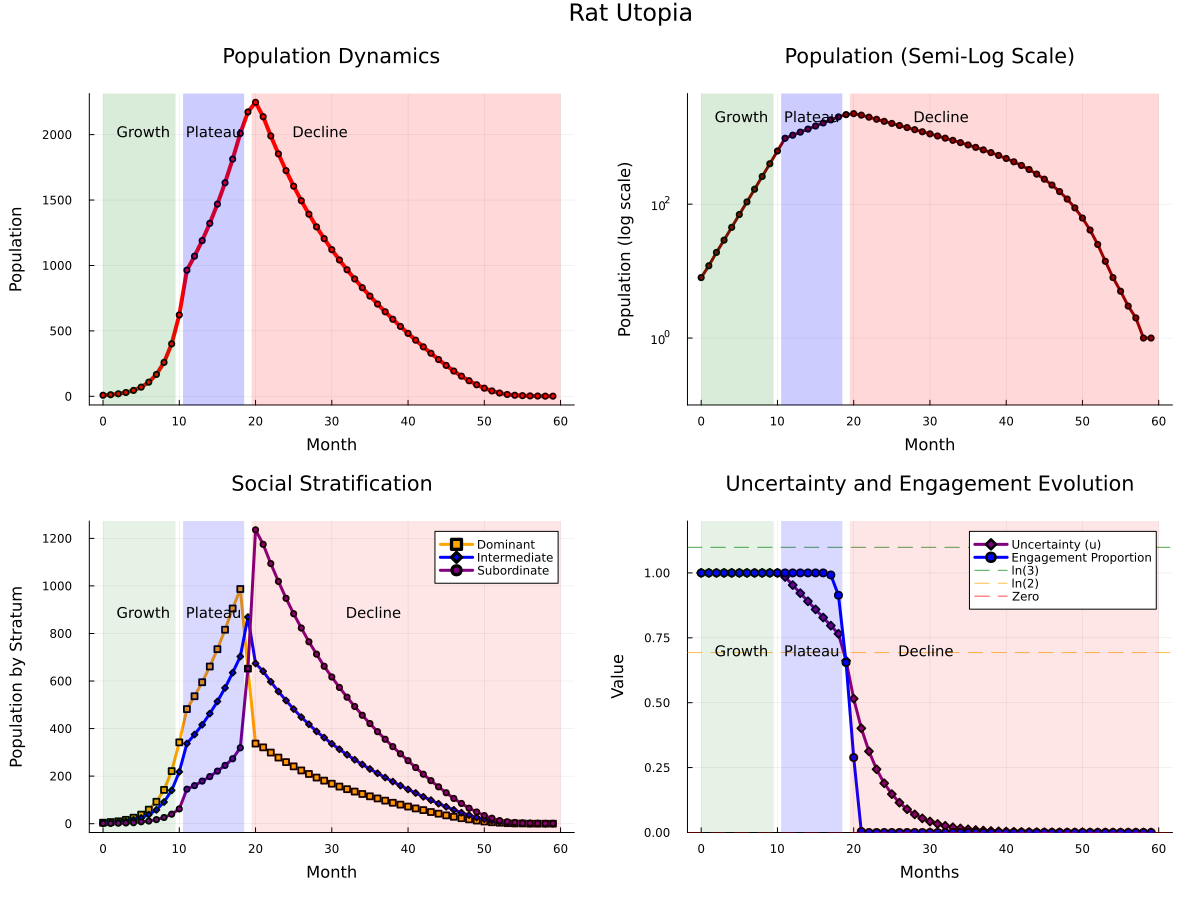


Generating visualization...


(StandardizedRatSimData[StandardizedRatSimData(0, 0.3333333333333333, 1.0, 5.0, 4.5, 2.5, 1.0, 1.0, 8, 0.0, 0.95, 0.285, "Growth", 4, 3, 1), StandardizedRatSimData(1, 0.3333333333333333, 1.0, 5.0, 4.5, 2.5, 1.0, 1.0, 12, 0.0, 0.95, 0.285, "Growth", 7, 4, 1), StandardizedRatSimData(2, 0.3333333333333333, 1.0, 5.0, 4.5, 2.5, 1.0, 1.0, 19, 0.0, 0.95, 0.285, "Growth", 10, 7, 2), StandardizedRatSimData(3, 0.3333333333333333, 1.0, 5.0, 4.5, 2.5, 1.0, 1.0, 29, 0.0, 0.95, 0.285, "Growth", 16, 10, 3), StandardizedRatSimData(4, 0.3333333333333333, 1.0, 5.0, 4.5, 2.5, 1.0, 1.0, 45, 0.0, 0.95, 0.24, "Growth", 25, 16, 4), StandardizedRatSimData(5, 0.3333333333333333, 1.0, 5.0, 4.5, 2.5, 1.0, 1.0, 70, 0.0, 0.95, 0.24, "Growth", 38, 24, 8), StandardizedRatSimData(6, 0.3333333333333333, 1.0, 5.0, 4.5, 2.5, 1.0, 1.0, 108, 0.0, 0.95, 0.24, "Growth", 59, 38, 11), StandardizedRatSimData(7, 0.3333333333333333, 1.0, 5.0, 4.5, 2.5, 1.0, 1.0, 167, 0.0, 0.95, 0.24, "Growth", 92, 58, 17), StandardizedRatSimData

In [11]:

main()